In [265]:
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt

from torch_geometric.datasets import EllipticBitcoinDataset
import pickle

torch.manual_seed(0)

# Our Graph Neural Network Model

We will use a two-layer Graph Attention Network.

In [80]:
class GAT(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        self.args = args
        super(GAT, self).__init__()
        #use our gat message passing 
        self.conv1 = GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = GATConv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x, edge_index, adj=None):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=self.args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=self.args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)
       

We use the `MetricManager` and `GnnTrainer` class that Ng and Taing defined to train their GAT. 

In [81]:
class MetricManager(object):
  def __init__(self, modes=["train", "test"]):

    self.output = {}

    for mode in modes:
      self.output[mode] = {}
      self.output[mode]["accuracy"] = []
      self.output[mode]["f1micro"] = []
      self.output[mode]["f1macro"] = []
      self.output[mode]["aucroc"] = []
      #new
      self.output[mode]["precision"] = []
      self.output[mode]["recall"] = []
      self.output[mode]["cm"] = []

  def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):

    # calculate metrics
    pred_labels = pred_scores > threshold
    accuracy = accuracy_score(target_labels, pred_labels)
    f1micro = f1_score(target_labels, pred_labels,average='micro')
    f1macro = f1_score(target_labels, pred_labels,average='macro')
    aucroc = roc_auc_score(target_labels, pred_scores)
    #new
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    cm = confusion_matrix(target_labels, pred_labels)

    # Collect results
    self.output[mode]["accuracy"].append(accuracy)
    self.output[mode]["f1micro"].append(f1micro)
    self.output[mode]["f1macro"].append(f1macro)
    self.output[mode]["aucroc"].append(aucroc)
    #new
    self.output[mode]["recall"].append(recall)
    self.output[mode]["precision"].append(precision)
    self.output[mode]["cm"].append(cm)
    
    return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
  
  # Get best results
  def get_best(self, metric, mode="test"):

    # Get best results index
    best_results = {}
    i = np.array(self.output[mode][metric]).argmax()

    # Output
    for m in self.output[mode].keys():
      best_results[m] = self.output[mode][m][i]
    
    return best_results

In [82]:
class GnnTrainer(object):
  
    def __init__(self, model):
        self.model = model
        self.metric_manager = MetricManager(modes=["train", "test"])

    def train(self, data_train, optimizer, criterion, scheduler, args):

        self.data_train = data_train
        for epoch in range(args['epochs']):
            self.model.train()
            optimizer.zero_grad()
            out = self.model(data_train.x, data_train.edge_index)

            out = out.reshape((data_train.x.shape[0]))
            loss = criterion(out[data_train.train_mask], data_train.y[data_train.train_mask].float())
            ## Metric calculations
            # train data
            target_labels = data_train.y.detach().cpu().numpy()[data_train.train_mask]
            pred_scores = out.detach().cpu().numpy()[data_train.train_mask]
            train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, target_labels)


            ## Training Step
            loss.backward()
            optimizer.step()

            # validation data
            self.model.eval()
            target_labels = data_train.y.detach().cpu().numpy()[data_train.test_mask]
            pred_scores = out.detach().cpu().numpy()[data_train.test_mask]
            test_acc, test_f1,test_f1macro, test_aucroc, test_recall, test_precision, test_cm = self.metric_manager.store_metrics("test", pred_scores, target_labels)

            if epoch%5 == 0:
                print(
                    "epoch: {} - loss: {:.4f} - accuracy train: {:.4f} - train roc: {:.4f}  - train f1micro: {:.4f}".format(epoch, loss.item(), train_acc, train_aucroc, train_f1)
                    + "accuracy test: {:.4f} - test roc: {:.4f}  - test f1micro: {:.4f}".format(test_acc, test_aucroc, test_f1)
                )

    # To predict labels
    def predict(self, data=None, unclassified_only=True, threshold=0.5):
        # evaluate model:
        self.model.eval()
        if data is not None:
            self.data_train = data

        out = self.model(self.data_train)
        out = out.reshape((self.data_train.x.shape[0]))

        if unclassified_only:
            pred_scores = out.detach().cpu().numpy()[self.data_train.test_mask]
        else:
            pred_scores = out.detach().cpu().numpy()

        pred_labels = pred_scores > threshold

        return {"pred_scores":pred_scores, "pred_labels":pred_labels}

    # To save metrics
    def save_metrics(self, save_name, path="./save/"):
        file_to_store = open(path + save_name, "wb")
        pickle.dump(self.metric_manager, file_to_store)
        file_to_store.close()

    # To save model
    def save_model(self, save_name, path="./save/"):
        torch.save(self.model.state_dict(), path + save_name)

# Elliptic Bitcoin Dataset

We use the `torch_geometric` implementation of this dataset which handles the donwloading of source files and preprocessing for us. 

In [83]:
data_train = EllipticBitcoinDataset(root="./data").data

In [84]:
print(data_train)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


In [85]:
num_node_features = data_train['x'].shape[1]
model = GAT(num_node_features, hparams['hidden_dim'], 1, hparams)

In [86]:
model.to(device)

GAT(
  (conv1): GATConv(165, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Model Training

We save the model locally after training finishes.

In [ ]:
# Hyperparameters
hparams={
    "epochs":50,
    'lr':0.01,
    'weight_decay':1e-5,
    'heads':2,
    'hidden_dim': 128, 
    'dropout': 0.5
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gat = GnnTrainer(model)
gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, hparams)

gnn_trainer_gat.save_metrics("GATprebuilt.results", path="./logs/")
gnn_trainer_gat.save_model("GATprebuilt.pt", path="./logs/")

Model training plots

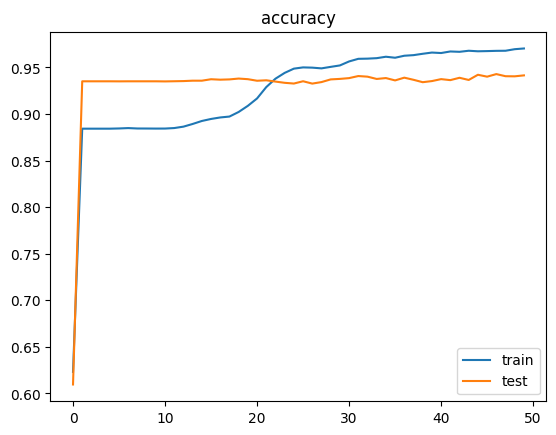

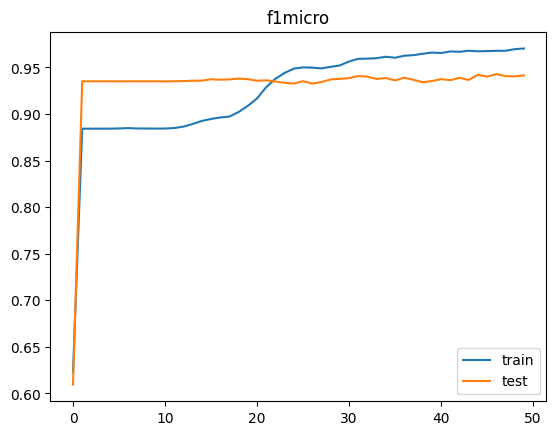

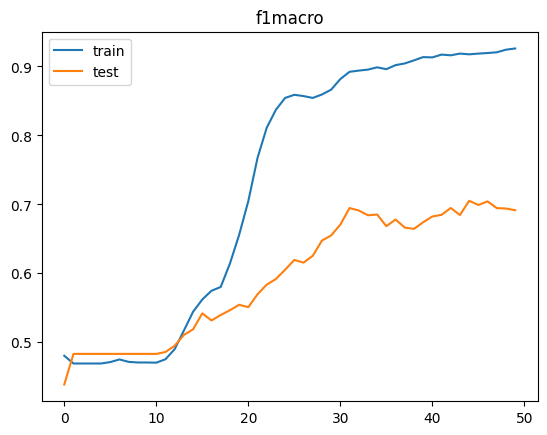

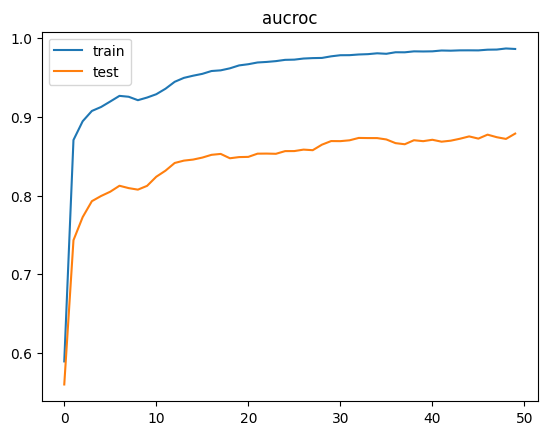

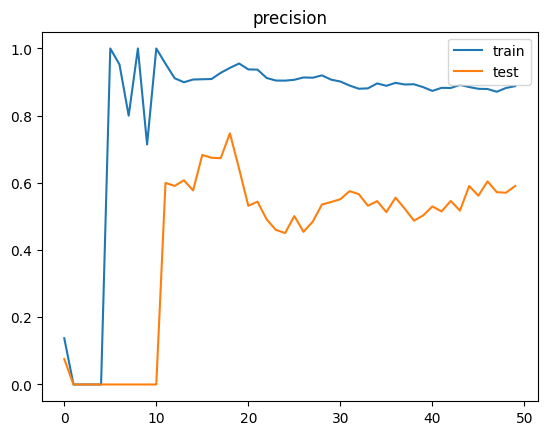

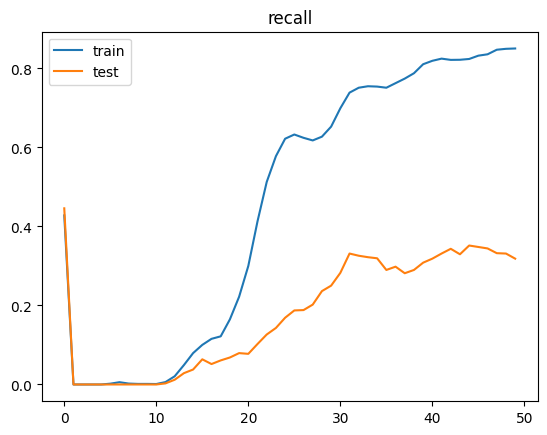

In [13]:
import matplotlib.pyplot as plt

metrics = gnn_trainer_gat.metric_manager.output['train']
test_metrics = gnn_trainer_gat.metric_manager.output['test']

for key in metrics.keys():
    if key == 'cm':
        continue
    
    plt.figure()
    plt.plot(metrics[key])
    plt.plot(test_metrics[key])
    plt.title(key)
    plt.legend(['train', 'test'])


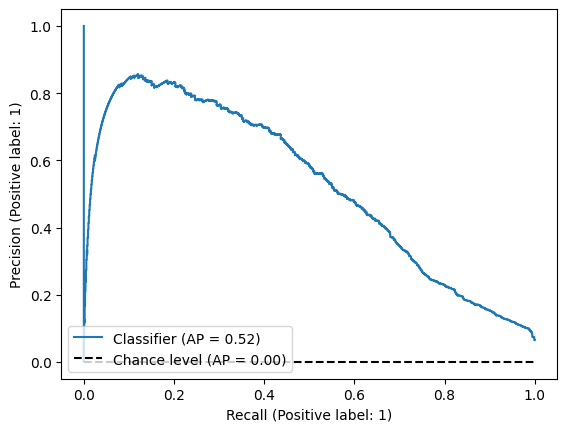

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

model.train(False)
y = model(data_train.x, data_train.edge_index)
y_test = y[data_train.test_mask].detach().numpy().flatten()
y_true = data_train.y[data_train.test_mask]

PrecisionRecallDisplay.from_predictions(y_true=y_true, y_pred=y_test, plot_chance_level=True)

Load in pre-trained model that was saved locally.

In [87]:
with open("./logs/GATprebuilt.pt", 'rb') as f:
    state_dict = torch.load(f)

In [88]:
model.load_state_dict(state_dict)

<All keys matched successfully>

# Local Explanation

We use the `GNNExplainer` algorithm to explain our model predictions.

In [89]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

using the `NeighborLoader` object to select a subset of our network dataset. 

In [296]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data=data_train,
    num_neighbors=[10, 10],
    input_nodes=data_train.test_mask,
)

We take an example that consists of at least 10 nodes and one illicit node.

In [ ]:
for batch in loader:
    pred = model(batch.x, batch.edge_index)
    if (batch['x'].shape[0] > 10 and (batch['y'] == 1).any()):
        break

print(batch)
print(batch.y)

Generate the explanation:

In [ ]:
explanation = explainer(batch.x, batch.edge_index)
print(explanation.edge_mask)
print(explanation.node_mask)
print(explanation.target)
print(explanation.prediction.flatten())

These are the kinds of plots that we get using the default plotting functionality in `torch_geometric`.

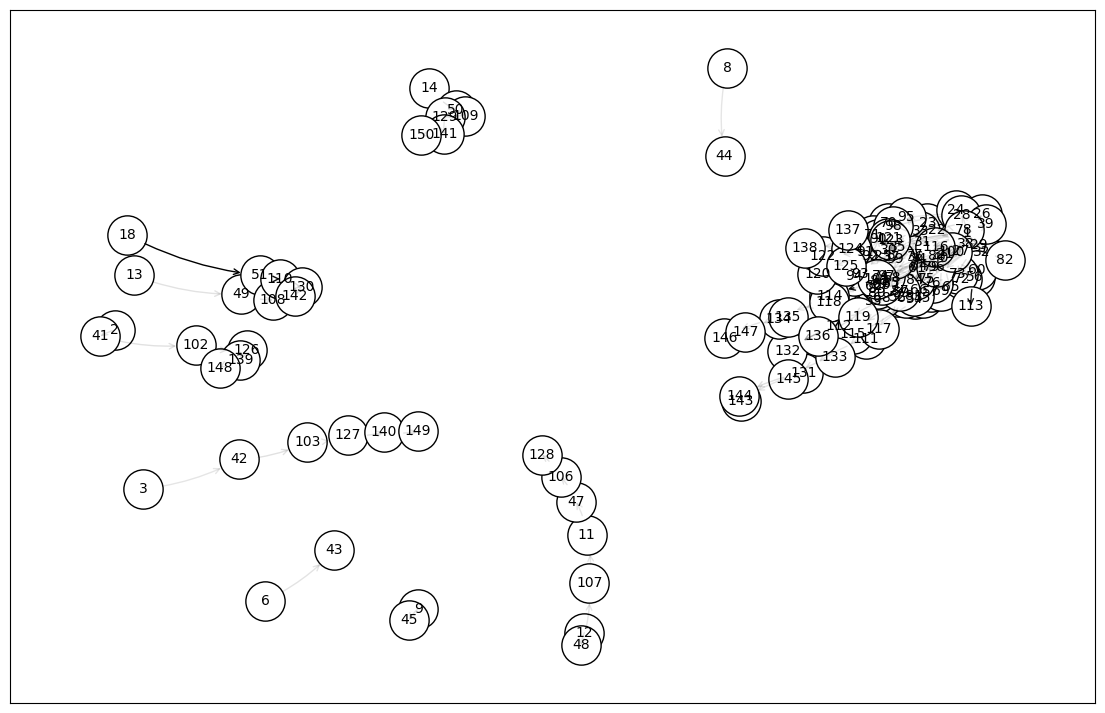

In [283]:
plt.figure(figsize=(14,9))
explanation.visualize_graph()

# Convert the Explanation into a Networkx Graph

In [99]:
from torch_geometric.utils import to_networkx

explanation['label'] = batch['y']
explanation['node_features'] = batch['x']
g = to_networkx(explanation, graph_attrs=['node_mask', 'edge_mask', 'target', 'label'], node_attrs=['node_features'])

Save our explanation and graph locally.

In [118]:
torch.save(explanation, 'explanation.pt')
torch.save(g, 'g.pt')

In [217]:
explanation = torch.load('explanation.pt')
g = torch.load('g.pt')

# Define our Colour Helper class

This will be useful for getting our node and edge colours according to their importance values.

In [194]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgba(self, val):
        return self.scalarMap.to_rgba(val, bytes=True)

    def get_rgb_str(self, val):
        r, g, b, a = self.get_rgba(val)
        return f"rgb({r},{g},{b})"

# Define our helper functions

The below functions prepares our `networkx` graph object to be plotted in `gravis`.

In [245]:
import numpy as np
import networkx as nx

def set_node_level_importance(g):
    '''Get node level importance'''
    # sum over each feature importance per node to get the overall node importance
    node_level_importance = np.array(g.graph['node_mask']).sum(axis=1)

    # assign the importance value to each node as an attribute
    node_level_importance_dict = { i : node_level_importance[i] for i in g.nodes }
    nx.set_node_attributes(g, node_level_importance_dict, name="importance")

def set_feature_level_importance_per_node(g):
    feature_level_importance = g.graph['node_mask']
    feature_level_importance_per_node = {
        node : feature_level_importance[node] for node in g.nodes
    }
    nx.set_node_attributes(g, feature_level_importance_per_node, name='feature_importance')

def set_edge_level_importance(g):
    '''Get edge level importance'''
    edge_level_importance = g.graph['edge_mask']
    
    # assign the importance value to each edge as an attribute
    edge_level_importance_dict = { edge : edge_level_importance[i] for i, edge in enumerate(g.edges) }
    nx.set_edge_attributes(g, edge_level_importance_dict, name="importance")

def set_node_shapes(g, pos_label_shape='rectangle', neg_label_shape='dot'):
    target = g.graph['target']
    for i, node in enumerate(g.nodes()):
        g.nodes[node]['shape'] = pos_label_shape if target[i] else neg_label_shape

def set_node_colors(g, cmap='winter'):
    '''Set colours based on importance values'''
    # scale our colourmap to be between the min-max importance
    vals = nx.get_node_attributes(g, 'importance').values()
    min_val, max_val = min(vals), max(vals)
    
    # initialise colour helper
    node_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each node
    node_colors = { 
        node : node_color_generator.get_rgb_str(data['importance']) for node, data in g.nodes(data=True) 
    }
    nx.set_node_attributes(g, node_colors, name='color')

def set_edge_colors(g, cmap='winter'):
    '''Set colours based on importance values'''
    # scale our colourmap to be between the min-max importance
    vals = nx.get_edge_attributes(g, 'importance').values()
    min_val, max_val = min(vals), max(vals)

    # initialise colour helper
    edge_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each edge
    edge_colors = {
        (u, v) : edge_color_generator.get_rgb_str(data['importance']) for u, v, data in g.edges(data=True)
    }
    nx.set_edge_attributes(g, edge_colors, name='color')


def rename_node_attribute(g, from_name:str, to_name:str):
    for _, data in g.nodes(data=True):
        try:
            data[to_name] = data.pop(from_name)
        except KeyError: 
            warnings.warn(f"Key {from_name} not found")

def set_node_label(g):
    label = g.graph['label']
    for node, data in g.nodes(data=True):
        data['label'] = label[node]

In [262]:
class ClickComponents():
    HEADER_COMPONENT = "Importance Values:"
    LABEL_COMPONENT = "Label: {}"
    NEWLINE = "\n"

    NODE_HEADER = LABEL_COMPONENT + NEWLINE + HEADER_COMPONENT + NEWLINE
    EDGE_HEADER = HEADER_COMPONENT + NEWLINE

    NODE_IMPORTANCE_ROW = "Node Importance: {}" + NEWLINE
    EDGE_IMPORTANCE_ROW = "Edge Importance: {}" + NEWLINE

    FEATURE_IMPORTANCE_ROW = "{0} : {1}" + NEWLINE


def set_node_click_display(g, feature_names:list[str]):
    for _, data in g.nodes(data=True):
        # initialise click information as empty string. 
        data['click'] = ""

        # add label information
        data['click'] += ClickComponents.NODE_HEADER.format(data['label'])

        # set header + node importance value
        node_attribution = data['importance']
        data['click'] += ClickComponents.NODE_IMPORTANCE_ROW.format(node_attribution)

        # set feature level importance values
        vals = data['feature_importance']
        idx = np.argsort(vals)              # default ascending order
        descending_order_idx = idx[::-1]    # change to descending order
        ordered_vals = np.array(vals)[descending_order_idx]
        ordered_names = np.array(feature_names)[descending_order_idx]
        
        for name, val in zip(ordered_names, ordered_vals):
            data['click'] += ClickComponents.FEATURE_IMPORTANCE_ROW.format(name, val)

def set_edge_click_display(g):
    for _, _, data in g.edges(data=True):
        # set header + edge attribution value
        edge_attribution = data['importance']
        data['click'] = ClickComponents.EDGE_HEADER
        data['click'] += ClickComponents.EDGE_IMPORTANCE_ROW.format(edge_attribution)

        # No feature level importance values for edges. 
        

Pass our `networkx` graph through the helper functions to prep it for `gravis`.

In [293]:
import gravis as gv

set_node_level_importance(g)
set_node_colors(g)
set_node_shapes(g)
set_feature_level_importance_per_node(g)

set_node_label(g)
set_node_click_display(g, [f"Feature {i}" for i in range(165)])

set_edge_level_importance(g)
set_edge_colors(g)
set_edge_click_display(g)

Finally, generate our plot.

In [294]:
gv.d3(
    g, 

    graph_height=700,

    node_size_data_source='importance',
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,

    edge_size_data_source='importance',
    use_edge_size_normalization=True,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,

    use_collision_force=True,
    collision_force_radius=50,
    collision_force_strength=1,

    show_details=True
)

In [242]:
g.graph['label']

[0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 2, 2, 2, 2]

In [202]:
explanation['target']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0])